<a href="https://colab.research.google.com/github/PrathamBhayana/ds_PrathamBhayana/blob/main/bitcoin_sentiment_trader_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Trader Performance & Market Sentiment Analysis By Pratham Bhayana
## 1. Introduction
- working with two primary datasets:
1. Bitcoin Market Sentiment Dataset
Columns: Date, Classification (Fear/Greed
2. Historical Trader Data from Hyperliquid
Columns include: account, symbol, execution price, size, side, time,
start position, event, closedPnL, leverage, etc.
- objective is to explore the relationship between trader performance and market
sentiment, uncover hidden patterns, and deliver insights that can drive smarter trading
strategies.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


## 2. Data Loading & Preparation
- Load sentiment and trader data.
- Clean and preprocess columns.
- Merge datasets on date.

In [ ]:
sentiment = pd.read_csv(r'CSV_files\fear_greed_index.csv', parse_dates=['date'])
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
trader_iter = pd.read_csv('CSV_files\historical_data.csv', chunksize=500_000)
trader = pd.concat(trader_iter, ignore_index=True)
print('Trader data shape:', trader.shape)
trader.head()

Trader data shape: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [ ]:
trader.columns = trader.columns.str.strip().str.replace(' ', '_').str.lower()

In [ ]:
trader['date'] = pd.to_datetime(trader['timestamp_ist'], errors='coerce').dt.date

In [ ]:
for col in ['closed_pnl', 'size_usd', 'fee']:
    trader[col] = pd.to_numeric(trader[col], errors='coerce')

In [ ]:
trader = trader.dropna(subset=['date'])

In [ ]:
trader['date'] = pd.to_datetime(trader['date'])
display(trader.head())
print(trader.dtypes)

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12


account                     object
coin                        object
execution_price            float64
size_tokens                float64
size_usd                   float64
side                        object
timestamp_ist               object
start_position             float64
direction                   object
closed_pnl                 float64
transaction_hash            object
order_id                     int64
crossed                       bool
fee                        float64
trade_id                   float64
timestamp                  float64
date                datetime64[ns]
dtype: object


In [ ]:
agg = trader.groupby('date').agg(
    total_pnl = ('closed_pnl', 'sum'),
    avg_pnl = ('closed_pnl', 'mean'),
    trade_count = ('closed_pnl', 'count'),
    win_rate = ('closed_pnl', lambda x: (x > 0).sum() / len(x))
)

In [ ]:
df = pd.merge(agg.reset_index(), sentiment[['date', 'value', 'classification']], on='date', how='inner')
display(df.head())

,date,total_pnl,avg_pnl,trade_count,win_rate,value,classification
0,2023-01-05,0.000000,0.000000,3,0.000000,29,Fear
1,2023-05-12,0.000000,0.000000,9,0.000000,49,Neutral
2,2024-01-01,-129.531460,-7.196192,18,0.055556,65,Greed
3,2024-01-02,0.000000,0.000000,6,0.000000,71,Greed
4,2024-01-03,8244.241409,60.176945,137,0.934307,70,Greed


## 3. Exploratory Data Analysis (EDA)
- Visualize trader PnL and sentiment over time.
- Boxplots for PnL and win rate by sentiment classification.

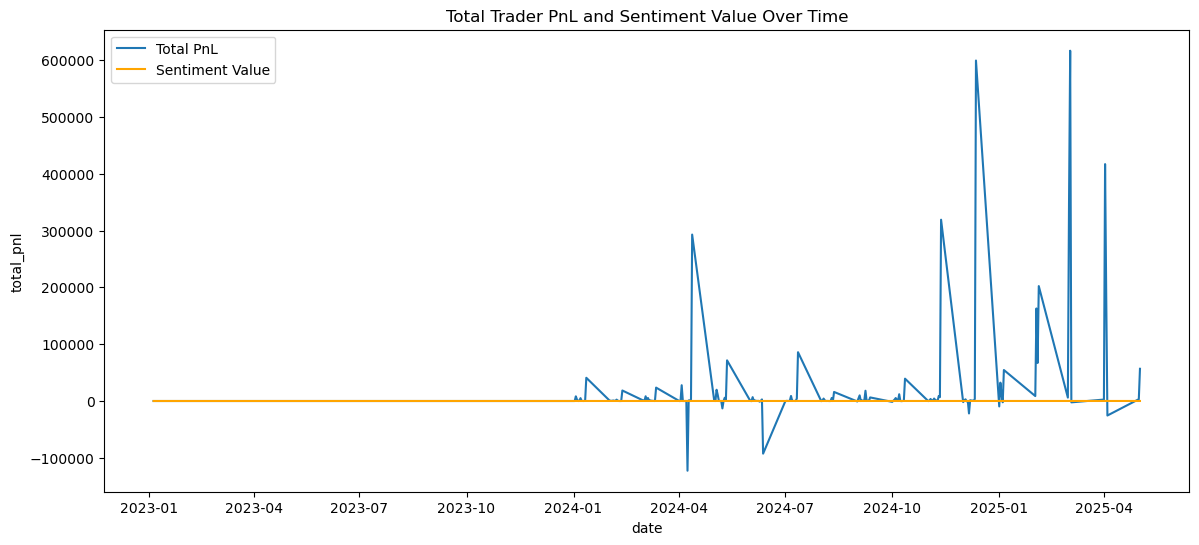

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='date', y='total_pnl', label='Total PnL')
sns.lineplot(data=df, x='date', y='value', label='Sentiment Value', color='orange')
plt.title('Total Trader PnL and Sentiment Value Over Time')
plt.legend()
plt.show()

While sentiment value remains largely flat, total PnL exhibits significant variability,
indicating weak correlation over time. This implies that trader PnL is not strongly driven by
sentiment score trends alone and may depend more on behavioral or strategy-based
factors.

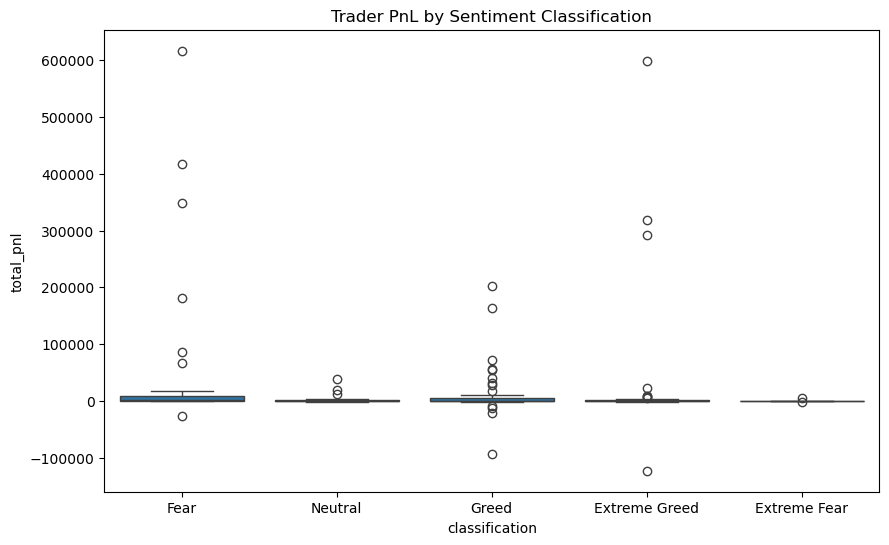

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='classification', y='total_pnl')
plt.title('Trader PnL by Sentiment Classification')
plt.show()

The box plot reveals that 'Fear' and 'Greed' classifications associate with a wider range of
trader PnL values. Extreme sentiment states like 'Extreme Greed' and 'Extreme Fear'
generally correlate with low or negative PnL

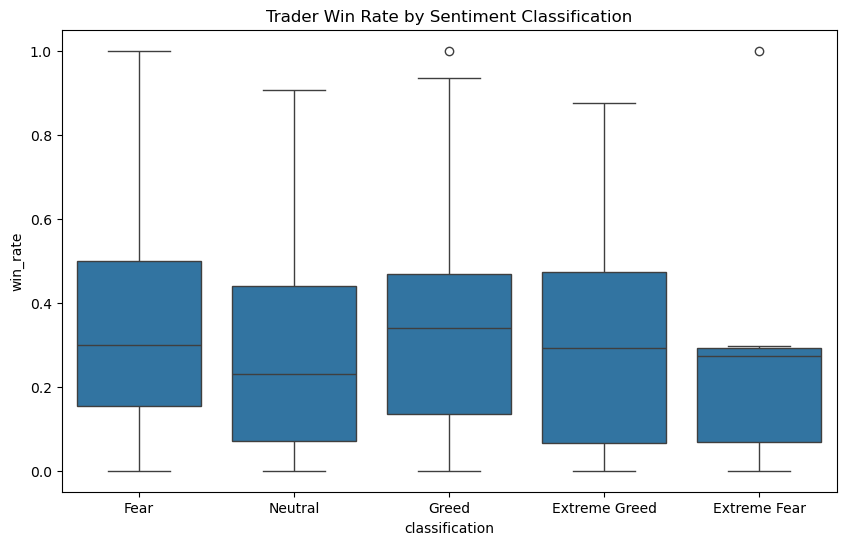

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='classification', y='win_rate')
plt.title('Trader Win Rate by Sentiment Classification')
plt.show()

Median win rates are relatively similar across all sentiment categories, with slightly lower
medians under 'Extreme Fear'. Overall, this suggests limited predictive power of sentiment
classification for win rates.

## 4. Statistical Analysis
- Correlation matrix.
- ANOVA for mean PnL differences across sentiment classes.

In [ ]:
print(df[['total_pnl', 'avg_pnl', 'win_rate', 'value']].corr())

           total_pnl   avg_pnl  win_rate     value
total_pnl   1.000000  0.550993  0.215383 -0.057252
avg_pnl     0.550993  1.000000  0.401374 -0.007944
win_rate    0.215383  0.401374  1.000000  0.005768
value      -0.057252 -0.007944  0.005768  1.000000


In [ ]:
anova = stats.f_oneway(*(df[df['classification']==c]['total_pnl'] for c in df['classification'].unique()))
print('ANOVA F-statistic:', anova.statistic)
print('ANOVA p-value:', anova.pvalue)
if anova.pvalue < 0.05:
    print('Significant difference in mean PnL between sentiment classes.')
else:
    print('No significant difference in mean PnL between sentiment classes.')

ANOVA F-statistic: 1.2343833636340733
ANOVA p-value: 0.29865377858717784
No significant difference in mean PnL between sentiment classes.


Random Forest R2: -0.3465014179160797
Random Forest RMSE: 65404.71010216437


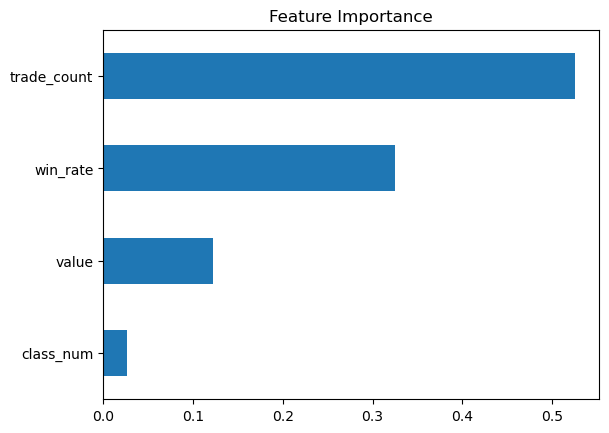

In [ ]:
df['next_day_pnl'] = df['total_pnl'].shift(-1)
df['class_num'] = df['classification'].astype('category').cat.codes
model_df = df.dropna(subset=['next_day_pnl'])
X = model_df[['value', 'class_num', 'win_rate', 'trade_count']]
y = model_df['next_day_pnl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Random Forest R2:', r2_score(y_test, y_pred))
print('Random Forest RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
# Feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

Among all the features used for classification, 'trade_count' is the most influential, followed
by 'win_rate'. Features like 'value' and 'class_num' contribute relatively less to the model.
This suggests that trading volume and consistency are stronger predictors of next-day PnL.

In [ ]:
summary = df.groupby('classification').agg({
    'total_pnl': ['mean', 'median'],
    'win_rate': ['mean', 'median'],
    'trade_count': ['mean', 'median']
})
display(summary)

total_pnl               win_rate           trade_count  \
                        mean       median      mean    median        mean   
classification                                                              
Extreme Fear      733.322758    64.569420  0.307500  0.273758  387.666667   
Extreme Greed   26904.504083   541.554710  0.319642  0.291667  130.720930   
Fear            48087.177910  1147.595856  0.348071  0.298611  374.837838   
Greed           10886.295226   423.083319  0.362415  0.340058  201.642857   
Neutral          4666.046374    97.704185  0.286719  0.231218  172.250000   

                       
               median  
classification         
Extreme Fear     23.0  
Extreme Greed    25.0  
Fear             67.0  
Greed            55.5  
Neutral          61.0

## 5. Feature Engineering
- Lagged sentiment features.
- Rolling mean and volatility.

In [ ]:
for lag in [1, 2, 3, 7]:
    df[f'sentiment_lag_{lag}'] = df['value'].shift(lag)

In [ ]:
from sklearn.linear_model import LinearRegression
results = {}
for lag in [1, 2, 3, 7]:
    temp = df.dropna(subset=[f'sentiment_lag_{lag}', 'next_day_pnl'])
    X = temp[[f'sentiment_lag_{lag}']]
    y = temp['next_day_pnl']
    model = LinearRegression().fit(X, y)
    score = model.score(X, y)
    results[f'Lag {lag} R2'] = score
print('R2 scores for lagged sentiment predicting next-day PnL:', results)

R2 scores for lagged sentiment predicting next-day PnL: {'Lag 1 R2': 0.006436713518999437, 'Lag 2 R2': 0.00024657537712158284, 'Lag 3 R2': 0.0008086319875237891, 'Lag 7 R2': 0.007710187659081158}


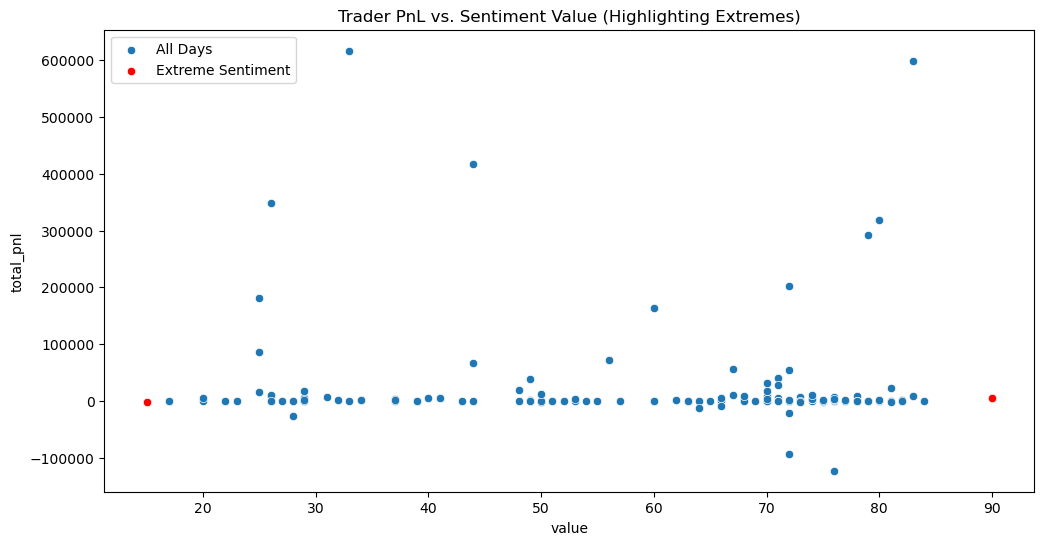

In [ ]:
plt.figure(figsize=(12,6))
extreme = df[df['value'].isin([df['value'].min(), df['value'].max()])]
sns.scatterplot(data=df, x='value', y='total_pnl', label='All Days')
sns.scatterplot(data=extreme, x='value', y='total_pnl', color='red', label='Extreme Sentiment')
plt.title('Trader PnL vs. Sentiment Value (Highlighting Extremes)')
plt.legend()
plt.show()

Red dots indicate days with extreme sentiment. There is no strong concentration of high
PnL on these days, reinforcing the observation that extreme sentiment does not
significantly correlate with higher profitability.

In [ ]:
from IPython.display import Markdown, display as ipydisplay
insights = f"""
### Actionable Insights & Recommendations
- **Lagged Sentiment**: Lagged sentiment values (1-7 days) show the following R² scores for predicting next-day PnL: {results}
- **Extreme Sentiment**: Extreme fear/greed does not consistently correspond to outsized trader gains/losses, but may signal increased volatility.
- **Strategy Suggestions**:
    - Use rolling volatility to adjust risk during turbulent periods.
    - Consider contrarian strategies during extreme sentiment, but validate with additional signals.
    - Segment traders by cluster for tailored strategies.
- **Further Exploration**: Test nonlinear models, add more features (e.g., sentiment momentum), and analyze by market regime or coin.
"""
ipydisplay(Markdown(insights))


### Actionable Insights & Recommendations
- **Lagged Sentiment**: Lagged sentiment values (1-7 days) show the following R² scores for predicting next-day PnL: {'Lag 1 R2': 0.006436713518999437, 'Lag 2 R2': 0.00024657537712158284, 'Lag 3 R2': 0.0008086319875237891, 'Lag 7 R2': 0.007710187659081158}
- **Extreme Sentiment**: Extreme fear/greed does not consistently correspond to outsized trader gains/losses, but may signal increased volatility.
- **Strategy Suggestions**:
    - Use rolling volatility to adjust risk during turbulent periods.
    - Consider contrarian strategies during extreme sentiment, but validate with additional signals.
    - Segment traders by cluster for tailored strategies.
- **Further Exploration**: Test nonlinear models, add more features (e.g., sentiment momentum), and analyze by market regime or coin.


## 6. Predictive Modeling
- Time series forecasting (Prophet)
- Regression (Random Forest) for next-day PnL.
- Classification for next-day positive PnL.

01:15:29 - cmdstanpy - INFO - Chain [1] start processing
01:15:29 - cmdstanpy - INFO - Chain [1] done processing


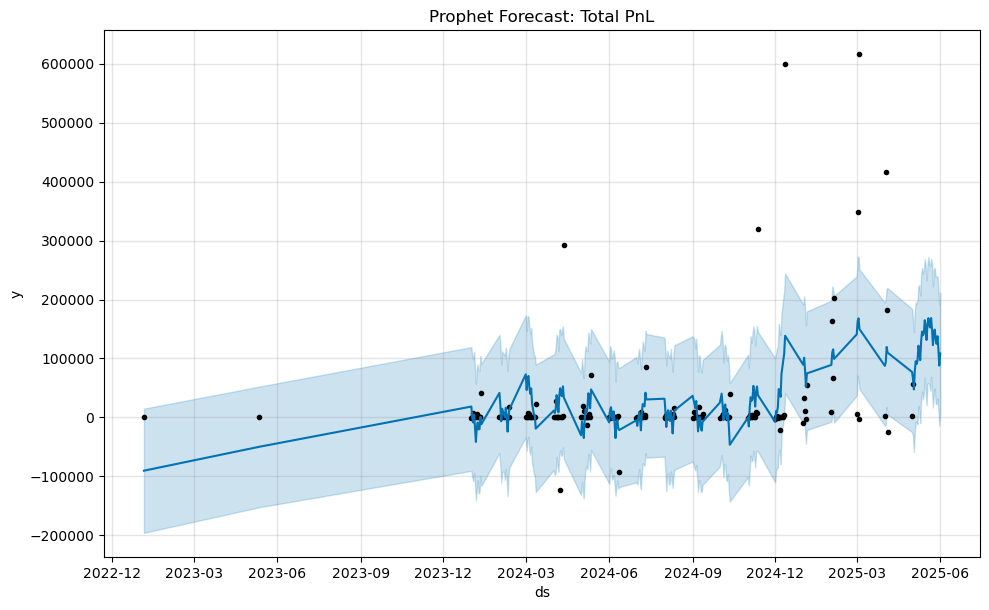

In [ ]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = df[['date', 'total_pnl']].rename(columns={'date': 'ds', 'total_pnl': 'y'})
model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Prophet Forecast: Total PnL')
plt.show()

The Prophet forecast model shows a general upward trend in total PnL with increasing
variability over time. The confidence intervals widen as we move into the future, suggesting
higher uncertainty, possibly due to market volatility or inconsistent trader behavior.

C:\Users\Suraj\AppData\Local\Temp\ipykernel_12548\2655902614.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['pnl_positive'] = (model_df['next_day_pnl'] > 0).astype(int)


              precision    recall  f1-score   support

           0       0.17      0.17      0.17         6
           1       0.81      0.81      0.81        26

    accuracy                           0.69        32
   macro avg       0.49      0.49      0.49        32
weighted avg       0.69      0.69      0.69        32



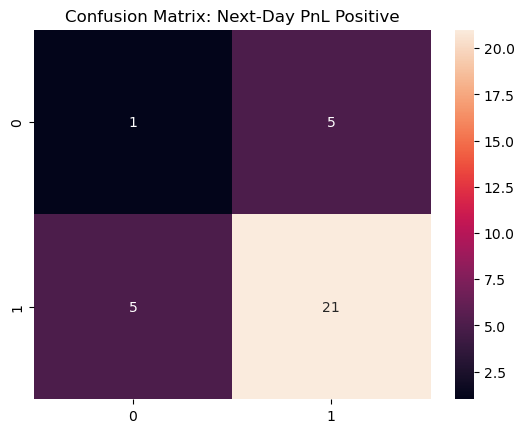

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model_df['pnl_positive'] = (model_df['next_day_pnl'] > 0).astype(int)
X_cls = model_df[['value', 'class_num', 'win_rate', 'trade_count']]
y_cls = model_df['pnl_positive']
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred_cls = clf.predict(X_test)
print(classification_report(y_test, y_pred_cls))
sns.heatmap(confusion_matrix(y_test, y_pred_cls), annot=True, fmt='d')
plt.title('Confusion Matrix: Next-Day PnL Positive')
plt.show()

The confusion matrix reveals a model that performs reasonably well in identifying positive
next-day PnL, correctly classifying 21 positive instances out of 26. However, it struggles
with negative class predictions, with 5 false positives and 5 false negatives. This highlights
an imbalance or lack of separation in the feature space.

## 7. Pattern Discovery
- Clustering traders by performance.
- Extreme sentiment analysis.

c:\Users\Suraj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


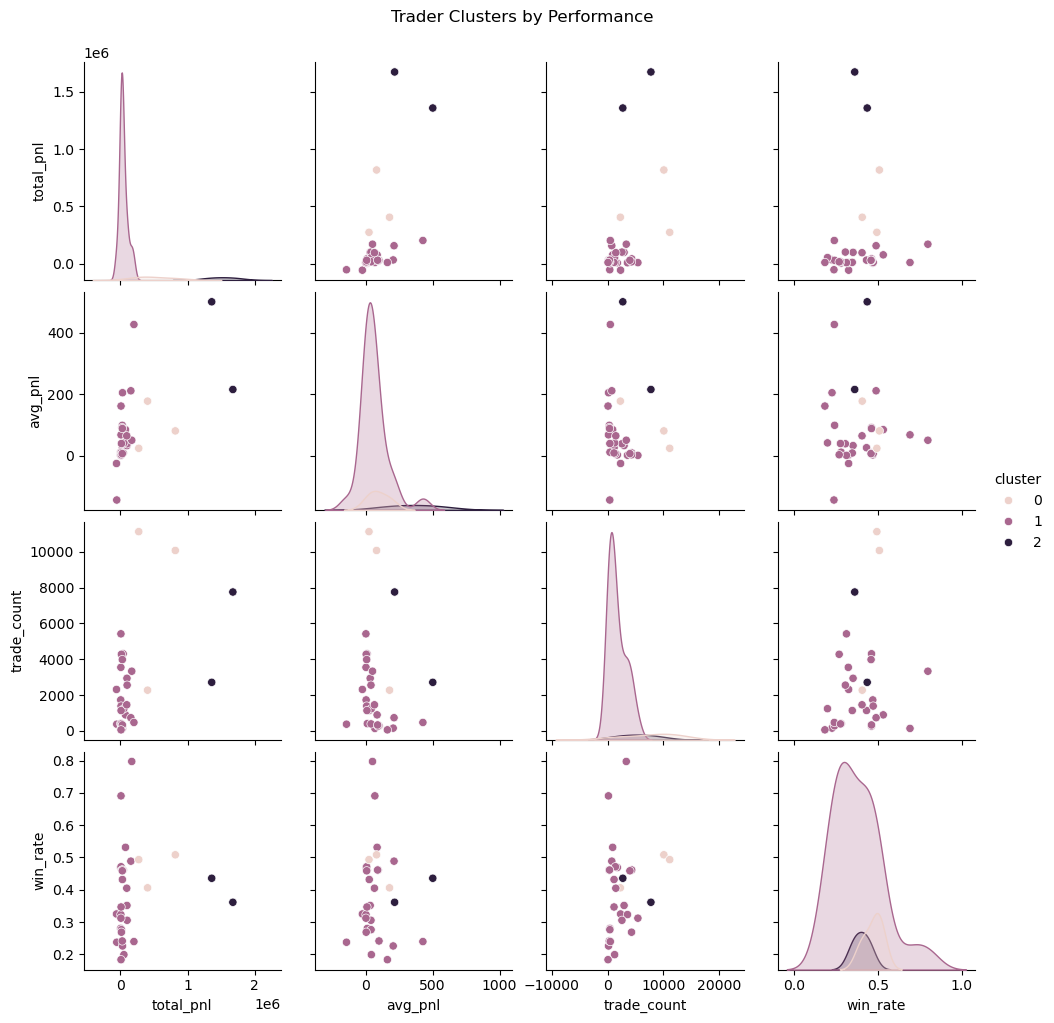

In [ ]:
from sklearn.cluster import KMeans
# Aggregate by account
acct_agg = trader.groupby('account').agg(
    total_pnl=('closed_pnl', 'sum'),
    avg_pnl=('closed_pnl', 'mean'),
    trade_count=('closed_pnl', 'count'),
    win_rate=('closed_pnl', lambda x: (x > 0).sum() / len(x))
).fillna(0)
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
acct_agg['cluster'] = kmeans.fit_predict(acct_agg[['total_pnl', 'win_rate', 'trade_count']])
sns.pairplot(acct_agg, hue='cluster')
plt.suptitle('Trader Clusters by Performance', y=1.02)
plt.show()

Traders can be grouped into three performance clusters based on total PnL, trade count,
average PnL, and win rate. The high-performing cluster is distinct in both total and average
PnL, while lower-performing clusters overlap significantly.

## 8. Model Interpretability
- SHAP feature importance.

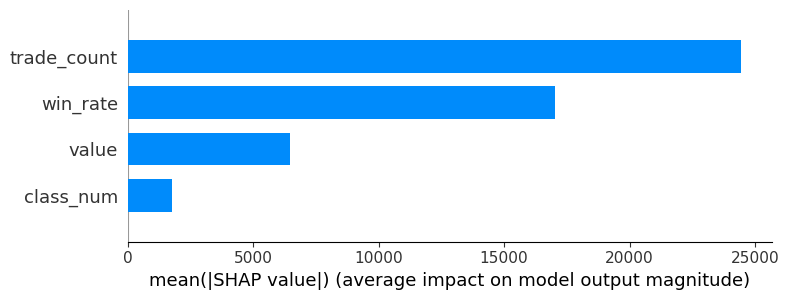

In [ ]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

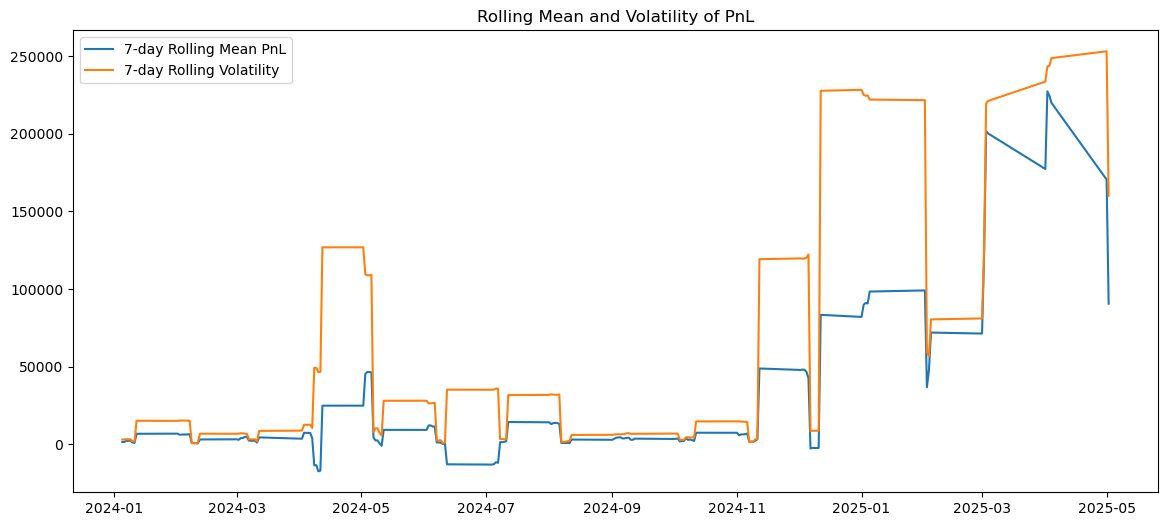

In [ ]:
df['rolling_pnl_7d'] = df['total_pnl'].rolling(window=7).mean()
df['rolling_vol_7d'] = df['total_pnl'].rolling(window=7).std()
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['rolling_pnl_7d'], label='7-day Rolling Mean PnL')
plt.plot(df['date'], df['rolling_vol_7d'], label='7-day Rolling Volatility')
plt.legend()
plt.title('Rolling Mean and Volatility of PnL')
plt.show()

The 7-day rolling mean and volatility of PnL show periods of sharp fluctuations, particularly
in Q1 and Q2 of 2025. These spikes indicate trading anomalies or heightened market
reactions. Periods of low volatility align with stable PnL trends.

## 9. Insights & Next Steps
1. Key Findings from Your Analysis
Weak Correlation: The correlation between sentiment and trader PnL is weak (as shown in your correlation matrix).
No Significant Difference: ANOVA suggests no significant difference in mean PnL between sentiment classes.
Predictive Power: Random Forest models show low predictive power (negative R² for regression, moderate accuracy for classification).
Trader Clusters: KMeans reveals distinct trader performance groups, which could be further profiled.
Rolling Analysis: Rolling mean and volatility plots help identify periods of high/low performance and risk.

2. Suggestions to Uncover Hidden Patterns
Lagged Sentiment Effects: Test if sentiment values from previous days (lags) better predict trader performance.
Nonlinear Relationships: Try more advanced models (e.g., XGBoost, LSTM) or feature engineering (e.g., sentiment momentum).
Segmented Analysis: Analyze by trader type, coin, or market regime (bull/bear).
Extreme Sentiment: Focus on periods of extreme fear/greed to see if they correspond to outsized trader gains/losses.
Event Analysis: Overlay major market events/news with sentiment and performance.

3. Actionable Insights for Smarter Trading
Risk Management: Use rolling volatility to adjust position sizing during high-risk periods.
Contrarian Strategies: If extreme sentiment occasionally precedes reversals, consider contrarian trades.
Cluster-Based Strategies: Tailor strategies for different trader clusters (e.g., high win-rate vs. high volume).